<a href="https://colab.research.google.com/github/legobitna/DeepLearning-basic/blob/main/8_2b_Building_Transfer_Learning_CNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Convolutional Neural Networks

CNNs are very similiar to Neural Networks: they are made up of neurons that have learnable weights and biases. And they still have a loss function on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

So what changes? **CNN architectures make the explicit assumption that the inputs are images**.

## Architecture Overview

![3-layer Neural Network](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

**Regular Neural Nets don't scale well to full images**. If the input images have the size 32x32x3 (32 wide, 32 high, 3 color channels), so a single neuron in a first hidden layer would have `32*32*3 = 3072` weights. How about 200x200x3 or larger? Clearly, this is wasteful and the huge number of parameters would quickly lead to overfitting.

![](http://cs231n.github.io/assets/cnn/cnn.jpeg)

**3D volumns of neurons**. CNN arranges its neurons in three dimensions (width, height, depth). Every layer of a CNN transforms the 3D input volumn to a 3D output volumn of neuron activations.

![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/ca8f34f3d28ea528.gif)

**Example Architecture**: Overview. We will go into more details below, but a simple ConvNet classification could have the architecture `[INPUT - CONV - RELU - POOL - FC]`. In more detail:

* INPUT `[32x32x3]` will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters (or kernel_size=12).
* RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
* POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
* FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

![](http://cs231n.github.io/assets/cnn/convnet.jpeg)

## Type of layers

There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular). Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function. Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t).

### Convolutional Layer

The Conv layer is the core building block of a Convolutional Network that does most of the computational heavy lifting.

|![alt text](http://cs231n.github.io/assets/cnn/depthcol.jpeg) | ![alt text](http://cs231n.github.io/assets/nn1/neuron_model.jpeg) |
|-|-|

Left: An example input volume in red (e.g. a 32x32x3 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input. Right: The neurons from the Neural Network chapter remain unchanged: They still compute a dot product of their weights with the input followed by a non-linearity, but their connectivity is now restricted to be local spatially.

If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a [5x5x3] region in the input volume, for a total of 5*5*3 = 75 weights (and +1 bias parameter). Notice that the extent of the connectivity along the depth axis must be 3, since this is the depth of the input volume.



#### Depth, Stride and Zero-padding

First, the **depth** of the output volume is a hyperparameter: it corresponds to the number of filters we would like to use.

Second, we must specify the **stride** with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

Sometimes it will be convenient to pad the input volume with zeros around the border. The size of this **zero-padding** is a hyperparameter.

**Real-world example**: The [Krizhevsky et al.](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) architecture that won the ImageNet challenge in 2012 accepted images of size `[227x227x3]`. On the first Convolutional Layer, it used neurons with receptive field size `F=11`, stride `S=4` and no zero padding `P=0`. Since `(227 - 11)/4 + 1 = 55`, and since the Conv layer had a depth of `K=96`, the Conv layer output volume had size `[55x55x96]`. Each of the `55*55*96` neurons in this volume was connected to a region of size `[11x11x3]` in the input volume. Moreover, all 96 neurons in each depth column are connected to the same `[11x11x3]` region of the input, but of course with different weights. As a fun aside, if you read the actual paper it claims that the input images were `224x224`, which is surely incorrect because `(224 - 11)/4 + 1` is quite clearly not an integer. This has confused many people in the history of ConvNets and little is known about what happened. The best guess is that Alex used zero-padding of 3 extra pixels that he does not mention in the paper.

#### Conv Layer Summary

To summarize, the Conv Layer:

* Accepts a volume of size  $W_1×H_1×D_1$
* Requires four hyperparameters:
    * Number of filters $K$,
    * their filter size $F$,
    * the stride $S$,
    * the amount of zero padding $P$.
* Produces a volumn of size $W_2×H_2×D_2$ where:
    * $W_2=(W_1−F+2P)/S+1$
    * $H_2=(H_1−F+2P)/S+1$ (i.e. width and height are computed equally by symmetry)
    * $D_2=K$
* It introduces $F⋅F⋅D_1$ weights per filter, for a total of $(F⋅F⋅D_1)⋅K$ weights and $K$ biases.
* In the output volume, the $d$-th depth slice (of size $W_2×H_2$) is the result of performing a valid convolution of the $d$-th filter over the input volume with a stride of $S$, and then offset by $d$-th bias.

### Pooling layers

The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

* Accepts a volume of size  $W_1×H_1×D_1$
* Requires four hyperparameters:
    * the filter size $F$,
    * the stride $S$,
* Produces a volumn of size $W_2×H_2×D_2$ where:
    * $W_2=(W_1−F)/S+1$
    * $H_2=(H_1−F)/S+1$ 
    * $D_2=D_1$
* Introduces zero parameters since it computes a fixed function of the input
* For Pooling layers, it is not common to pad the input using zero-padding

It is worth noting that there are only two commonly seen variations of the max pooling layer found in practice: A pooling layer with $F=3,S=2$ (also called overlapping pooling), and more commonly $F=2,S=2$. Pooling sizes with larger receptive fields are too destructive.

In addition to max pooling, the pooling units can also perform other functions, such as average pooling or even L2-norm pooling. Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.

| ![alt text](http://cs231n.github.io/assets/cnn/pool.jpeg) | ![alt text](http://cs231n.github.io/assets/cnn/maxpool.jpeg) |
|-|-|

### The final layer

After the last convolutional layer, the data is in the form of a "cube". There are two ways of feeding it through the final dense layer.

The first one is to flatten the cube of data into a vector and then feed it to the softmax layer. Sometimes, you can even add a dense layer before the softmax layer. This tends to be expensive in terms of the number of weights. A dense layer at the end of a convolutional network can contain more than half the weights of the whole neural network.

![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/a44aa392c7b0e32a.png)

Instead of using an expensive dense layer, we can also split the incoming data "cube" into as many parts as we have classes, average their values and feed these through a softmax activation function. This way of building the classification head costs 0 weights. In Keras, there is a layer for this: `tf.keras.layers.GlobalAveragePooling2D()`.

### Layer Pattern

![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/e1a214a170957da1.png)

The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common ConvNet architecture follows the pattern:

```
INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
```


> The padding parameter in convolutional layers can have two values:
>
> * "same": pad with zeros so as to produce outputs of the same width/height as the input
> * "valid": no padding, only use real pixels

## CNN Architectures

There are several architectures in the field of Convolutional Networks that have a name. The most common are:

* **LeNet.** The first successful applications of Convolutional Networks were developed by Yann LeCun in 1990’s. Of these, the best known is the [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture that was used to read zip codes, digits, etc.

* **AlexNet.** The first work that popularized Convolutional Networks in Computer Vision was the [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks), developed by Alex Krizhevsky, Ilya Sutskever and Geoff Hinton. The AlexNet was submitted to the [ImageNet ILSVRC challenge](http://www.image-net.org/challenges/LSVRC/2014/) in 2012 and significantly outperformed the second runner-up (top 5 error of 16% compared to runner-up with 26% error). The Network had a very similar architecture to LeNet, but was deeper, bigger, and featured Convolutional Layers stacked on top of each other (previously it was common to only have a single CONV layer always immediately followed by a POOL layer).

* **ZF Net**. The ILSVRC 2013 winner was a Convolutional Network from Matthew Zeiler and Rob Fergus. It became known as the [ZFNet](http://arxiv.org/abs/1311.2901) (short for Zeiler & Fergus Net). It was an improvement on AlexNet by tweaking the architecture hyperparameters, in particular by expanding the size of the middle convolutional layers and making the stride and filter size on the first layer smaller.

* **GoogLeNet**. The ILSVRC 2014 winner was a Convolutional Network from [Szegedy et al.](http://arxiv.org/abs/1409.4842) from Google. Its main contribution was the development of an Inception Module that dramatically reduced the number of parameters in the network (4M, compared to AlexNet with 60M). Additionally, this paper uses Average Pooling instead of Fully Connected layers at the top of the ConvNet, eliminating a large amount of parameters that do not seem to matter much. There are also several followup versions to the GoogLeNet, most recently [Inception-v4](http://arxiv.org/abs/1602.07261).

* **VGGNet**. The runner-up in ILSVRC 2014 was the network from Karen Simonyan and Andrew Zisserman that became known as the [VGGNet](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). Its main contribution was in showing that the depth of the network is a critical component for good performance. Their final best network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end. A downside of the VGGNet is that it is more expensive to evaluate and uses a lot more memory and parameters (140M). Most of these parameters are in the first fully connected layer, and it was since found that these FC layers can be removed with no performance downgrade, significantly reducing the number of necessary parameters.

* **ResNet**. [Residual Network](http://arxiv.org/abs/1512.03385) developed by Kaiming He et al. was the winner of ILSVRC 2015. It features special skip connections and a heavy use of batch normalization. The architecture is also missing fully connected layers at the end of the network. ResNets are currently by far state of the art Convolutional Neural Network models and are the default choice for using ConvNets in practice (as of May 10, 2016).

### Practice



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.3.0


**TensorFlow Datasets**

In [2]:
import tensorflow_datasets as tfds

mnist = tfds.image.MNIST()

# Describe the dataset with DatasetInfo
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000
assert mnist.info.splits['test'].num_examples == 10000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

# Load data from disk as tf.data.Datasets
datasets = mnist.as_dataset()
train_dataset, test_dataset = datasets['train'], datasets['test']
assert isinstance(train_dataset, tf.data.Dataset)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_dataset.element_spec

{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [4]:
info = mnist.info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


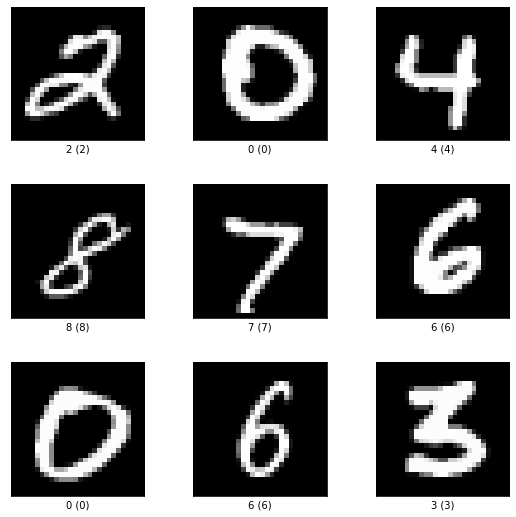

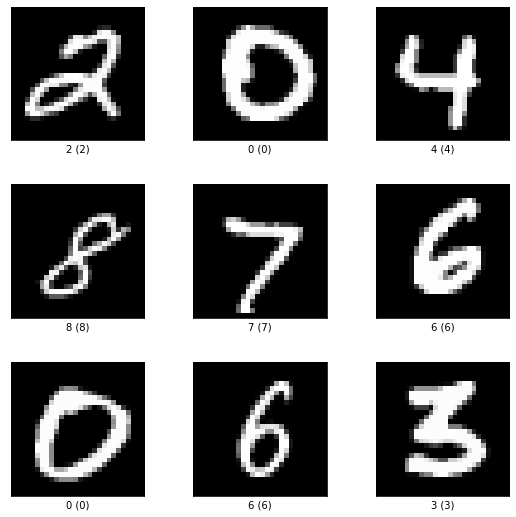

In [5]:
tfds.show_examples(info, test_dataset)

Label: 4


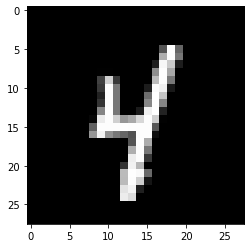

In [6]:
for mnist_example in train_dataset.take(1):  # Only take a single example
    image, label = mnist_example["image"], mnist_example["label"]

    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

In [7]:
BATCH_SIZE = 128
NUM_EXAMPLES = 60000
NUM_TESTING = 10000

def preprocess(ds):
    x = tf.cast(ds['image'], tf.float32) / 255.0
    return x, ds['label']

train_dataset = train_dataset.map(preprocess).cache().repeat().shuffle(1024).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Build simple fully connected layers (dense with dropout)

```
Model: "Your simple DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
=================================================================
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
```

In [8]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input, BatchNormalization

# TODO
def build_dnn():
    model = tf.keras.models.Sequential([
      # YOUR CODE HERE
      Flatten(input_shape=(28,28,1)),
      Dense(128,activation='relu'),
      Dropout(0.2),
      Dense(64,activation="relu"),
      Dense(10,activation="softmax")

      
    ])
    return model

In [9]:
model = build_dnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=20, steps_per_epoch=int(NUM_EXAMPLES/BATCH_SIZE),
          validation_data=test_dataset, validation_steps=int(NUM_TESTING/BATCH_SIZE))

Epoch 1/20
468/468 [==============================] - 8s 16ms/step - loss: 0.3822 - accuracy: 0.8877 - val_loss: 0.1579 - val_accuracy: 0.9533
Epoch 2/20
468/468 [==============================] - 2s 5ms/step - loss: 0.1658 - accuracy: 0.9507 - val_loss: 0.1173 - val_accuracy: 0.9639
Epoch 3/20
468/468 [==============================] - 2s 5ms/step - loss: 0.1249 - accuracy: 0.9624 - val_loss: 0.0960 - val_accuracy: 0.9704
Epoch 4/20
468/468 [==============================] - 2s 5ms/step - loss: 0.0989 - accuracy: 0.9698 - val_loss: 0.0837 - val_accuracy: 0.9748
Epoch 5/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0840 - accuracy: 0.9740 - val_loss: 0.0756 - val_accuracy: 0.9763
Epoch 6/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0732 - accuracy: 0.9781 - val_loss: 0.0750 - val_accuracy: 0.9774
Epoch 7/20
468/468 [==============================] - 2s 3ms/step - loss: 0.0663 - accuracy: 0.9790 - val_loss: 0.0707 - val_accuracy: 0.9777
Epoch

## Build LeNet-5

![alt text](https://i.imgur.com/OD6XAUO.jpg)

```
Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_38 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               400500    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5010      
=================================================================
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
_________________________________________________________________
```

In [14]:
def build_lenet5():
    model = tf.keras.models.Sequential()
    # YOUR CODE HERE
    
    model.add( Conv2D(kernel_size=(5,5),filters=20,activation='relu',input_shape=(28,28,1)) )
    model.add( MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(  Conv2D(kernel_size=(5,5),filters=50,activation='relu') )
    model.add(  MaxPooling2D(pool_size=(2,2), strides=(2,2)) )

    model.add( Flatten())
    model.add( Dense(units=500,activation='relu'))
    model.add( Dense(units=10,activation='softmax') )
    return model

In [15]:
lenet = build_lenet5()
lenet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               400500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [16]:
lenet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lenet.fit(train_dataset, epochs=20, steps_per_epoch=int(NUM_EXAMPLES/BATCH_SIZE),
          validation_data=test_dataset, validation_steps=int(NUM_TESTING/BATCH_SIZE))

Epoch 1/20
468/468 [==============================] - 2s 4ms/step - loss: 0.1781 - accuracy: 0.9467 - val_loss: 0.0560 - val_accuracy: 0.9833
Epoch 2/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.0383 - val_accuracy: 0.9881
Epoch 3/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0321 - accuracy: 0.9897 - val_loss: 0.0279 - val_accuracy: 0.9911
Epoch 4/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0336 - val_accuracy: 0.9896
Epoch 5/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0294 - val_accuracy: 0.9913
Epoch 6/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0287 - val_accuracy: 0.9922
Epoch 7/20
468/468 [==============================] - 2s 4ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0298 - val_accuracy: 0.9925
Epoch 

In [ ]:
lenet.save('lenet5.h5')

##Build AlexNet



```
Model: "AlexNet" 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_40 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 256)       884992    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 4096)              37752832  
_________________________________________________________________
dense_22 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_23 (Dense)             (None, 1000)              4097000   
=================================================================
Total params: 62,378,344
Trainable params: 62,378,344
Non-trainable params: 0
_________________________________________________________________
```

![alt text](https://i.imgur.com/pHF2INm.png)

In [19]:
def build_alexnet():
    model = tf.keras.models.Sequential([
      Conv2D(96,kernel_size=(11,11),strides=(4,4),input_shape=(227,227,3),activation='relu'),
      MaxPooling2D(pool_size=(3,3),strides=(2,2)),

      Conv2D(256,kernel_size=(5,5),padding='same',activation='relu'),
      MaxPooling2D(pool_size=(3,3),strides=(2,2)),

      Conv2D(384,kernel_size=(3,3),padding='same',activation='relu'),
      Conv2D(384,kernel_size=(3,3),padding='same',activation='relu'),
      Conv2D(256,kernel_size=(3,3),padding='same',activation='relu'),

      MaxPooling2D(pool_size=(3,3),strides=(2,2)),

      Flatten(),
      Dense(4096, activation='relu'),
      Dense(4096, activation='relu'),
      Dense(1000, activation='softmax')
      
    ])
    return model

model = build_alexnet()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 256)      

### Challenge Time!

**CNN architecture**

Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels.

What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

In [ ]:
# Your answer in number or words



## Build VGG16

![](https://media5.datahacker.rs/2019/02/vgg.png)

```
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_159 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 56, 56, 256)       590080    
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 28, 28, 512)       1180160   
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 28, 28, 512)       2359808   
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 28, 28, 512)       2359808   
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 14, 14, 512)       2359808   
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
dense_40 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_41 (Dense)             (None, 1000)              4097000   
=================================================================
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_________________________________________________________________
```

We load the real transfer learning VGG16 from Keras to get the parameters from it!

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
vgg16.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Get the weights from the real VGG16 model!

In [ ]:
weights = vgg16.get_weights()

In [ ]:
def build_vgg16():
      model = tf.keras.models.Sequential([                
        # YOUR CODE HERE

        
  
      ])
      return model

If you build your model correctly then it can load the pretrained weigths of VGG16 without any error! It's gonna be impressive since you have build the VGG-16 from scratch!

In [ ]:
model = build_vgg16()
model.set_weights(weights)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

## Neural Style Transfer Art Competition

**Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto)**